# Simple Speech Classification (Spectrogram)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.3.0'

Data from https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
speech_data = np.load("/content/drive/My Drive/datasets/speech_wav_8000.npz")

In [4]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [5]:
import IPython.display as ipd

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # sample rate
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  30615
Wave data shape :  (8000,)
label :  ['off']


In [6]:
def wav2spec(wav, fft_size=258): 
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [7]:
spec = wav2spec(data)
print("Spectrogram shape : ",spec.shape)

Spectrogram shape :  (130, 126)


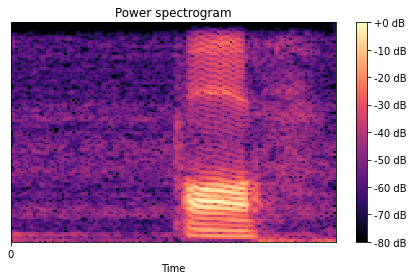

In [8]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [9]:
data_spec = []
for wav in speech_data["wav_vals"]:
    stft = wav2spec(wav)
    data_spec.append(stft)

data_spec = np.array(data_spec)
data_spec.shape

(50620, 130, 126)

In [10]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [11]:
label_data = []
for label in speech_data["label_vals"]:
    label_data.append(label_value[label[0]])
label_data = np.array(label_data)

In [12]:
train_spec, test_spec, train_label, test_label = train_test_split(data_spec, label_data, 
                                                                test_size=0.1, 
                                                                shuffle=True)

train_spec = train_spec.reshape(-1, 130, 126, 1)
test_spec = test_spec.reshape(-1, 130, 126, 1)

In [13]:
# memory problem
del speech_data
del data_spec
del label_data

In [14]:
print("train data : ", train_spec.shape)
print("train labels : ", test_spec.shape)
print("test data : ", train_label.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126, 1)
train labels :  (5062, 130, 126, 1)
test data :  (45558,)
test labels :  (5062,)


In [15]:
batch_size = 256
max_epochs = 50

checkpoint_dir ='./drive/My Drive/train_ckpt/spec/exp1'

In [16]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [18]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=tf.keras.initializers.he_normal())(input_tensor)
x = layers.BatchNormalization()(x)

skip = layers.MaxPool2D()(x)
x = layers.Conv2D(16, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=tf.keras.initializers.he_normal())(skip)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = tf.concat([x, skip], -1)

skip = layers.MaxPool2D()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=tf.keras.initializers.he_normal())(skip)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = tf.concat([x, skip], -1)

x = layers.Conv2D(32, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(12, activation='relu')(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

In [19]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   optimizer=optimizer,
                   metrics=['accuracy'])

In [20]:
model_spec.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 130, 126, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [22]:
history = model_spec.fit(train_dataset, 
                         epochs=max_epochs,
                         steps_per_epoch=len(train_spec)//batch_size,
                         validation_data=test_dataset,
                         validation_steps=len(test_spec)//batch_size,
                         callbacks=[cp_callback]
                         )

Epoch 1/50
177/177 [==============================] - ETA: 0s - loss: 1.7548 - accuracy: 0.4249
Epoch 00001: val_loss improved from inf to 1.56810, saving model to ./drive/My Drive/train_ckpt/spec/exp1
177/177 [==============================] - 20s 114ms/step - loss: 1.7548 - accuracy: 0.4249 - val_loss: 1.5681 - val_accuracy: 0.4846
Epoch 2/50
177/177 [==============================] - ETA: 0s - loss: 0.8818 - accuracy: 0.7148
Epoch 00002: val_loss improved from 1.56810 to 0.70511, saving model to ./drive/My Drive/train_ckpt/spec/exp1
177/177 [==============================] - 19s 109ms/step - loss: 0.8818 - accuracy: 0.7148 - val_loss: 0.7051 - val_accuracy: 0.7893
Epoch 3/50
177/177 [==============================] - ETA: 0s - loss: 0.6150 - accuracy: 0.8015
Epoch 00003: val_loss improved from 0.70511 to 0.53299, saving model to ./drive/My Drive/train_ckpt/spec/exp1
177/177 [==============================] - 19s 109ms/step - loss: 0.6150 - accuracy: 0.8015 - val_loss: 0.5330 - val_a

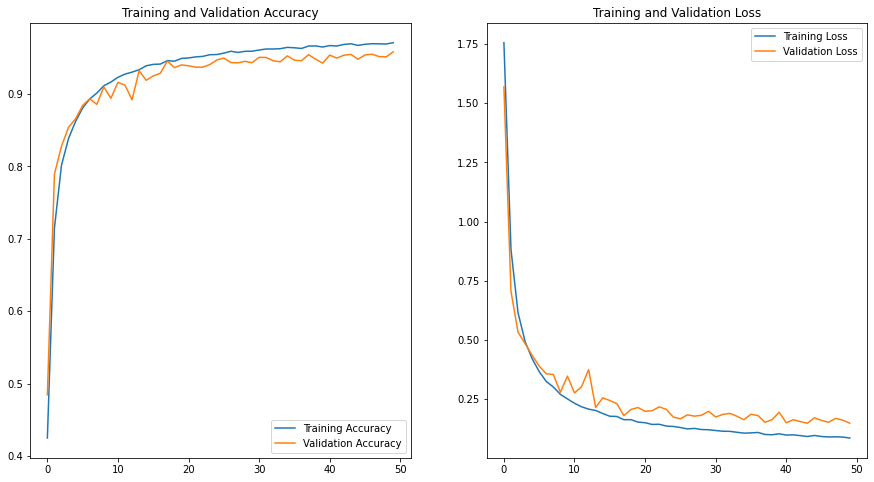

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model_spec.load_weights(checkpoint_dir)

In [25]:
results = model_spec.evaluate(test_dataset)

20/20 [==============================] - 1s 32ms/step - loss: 0.1450 - accuracy: 0.9589


In [26]:
print("loss value: {:.3f}".format(results[0]))
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.145
accuracy value: 95.8910%


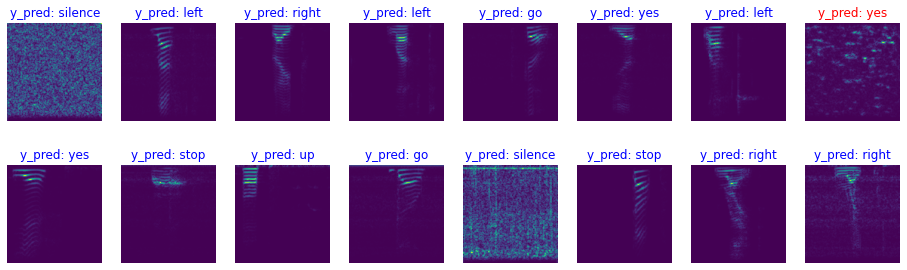

In [27]:
inv_label_value = {v: k for k, v in label_value.items()}

test_batch_size = 16
batch_index = np.random.choice(len(test_spec), size=test_batch_size, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(inv_label_value[np.argmax(py)]), color='blue')
  else:
    p.set_title("y_pred: {}".format(inv_label_value[np.argmax(py)]), color='red')
  p.imshow(px.reshape(130, 126))
  p.axis('off')